In [25]:
import io
import os
import math
import sys
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D projection of plot
%matplotlib inline

import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

2.2.5
1.15.0


Quick look at data:

Orientation: [ 0.         55.38461538 55.38461538]

1.) Voxels
Min: 0.0014597149565815926, Max: 0.5, Shape: (9, 9, 9, 1)


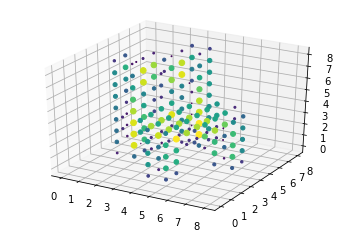

2.) PCA
[[ 0.74555224  0.26463488  0.03561563]
 [ 0.26463488  1.17046809 -0.39254314]
 [ 0.03561563 -0.39254314  0.74228776]]
3.) planar projection
Min: -1.4173123836517334, Max: 1.3068912029266357, Shape: (128, 128, 1)


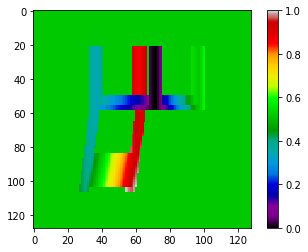

4.) cylindrical projection
Min: 0.0, Max: 1.4548304080963135, Shape: (128, 128, 1)


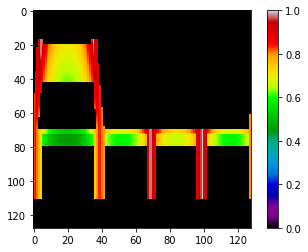

5.) spherical projection
Min: 0.0, Max: 2.203505277633667, Shape: (128, 128, 1)


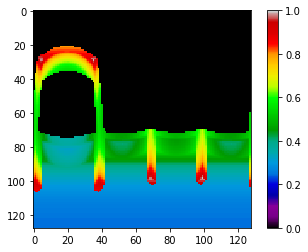

In [26]:
# Utility functions: 
# Plot Voxels as a point cloud:
def plot_voxels(nvoxels, resolution=9, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels.max() - nvoxels[x, z, y, 0] ))
    ax.scatter(xs, ys, zs, s=sizes, c=sizes, alpha=alpha)
    
# Store Numpy array in SqLite database:
def adapt_array(arr):
    """
    Save Numpy array to SqLite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    """ 
    Load Numpy array from Sqlite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

# Load database:
data_path = os.path.join("data", "data.db")
data_test_path = os.path.join("data", "data_test.db")
conn = sqlite3.connect(data_path, isolation_level=None, detect_types=sqlite3.PARSE_DECLTYPES)
query = "SELECT orientation FROM data WHERE id = 33"
cursor = conn.cursor()
cursor.execute(query)
print("Orientation: {}\n".format(cursor.fetchall()[0][0]))

query = "SELECT orientation, voxels, pca, plane, cylinder, sphere FROM data WHERE id = 31"
cursor = conn.cursor()
cursor.execute(query)
sample = cursor.fetchall()
orientation, voxels, pca, plane, cylinder, sphere = sample[0]
nvoxels = np.asarray(voxels).reshape((9, 9, 9, 1))

# Preview of different 3D object representations:
print("1.) Voxels")
print("Min: {}, Max: {}, Shape: {}".format(nvoxels.min(), nvoxels.max(), nvoxels.shape))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_voxels(nvoxels, resolution=9, point_size=70)
plt.show()

print("2.) PCA")
print(pca)

print("3.) planar projection")
print("Min: {}, Max: {}, Shape: {}".format(plane.min(), plane.max(), plane.shape))
plane = plane.reshape(128, 128)
plane -= plane.min()
plane /= plane.max()
plt.imshow(plane,cmap='nipy_spectral')
plt.colorbar()
plt.show()

print("4.) cylindrical projection")
print("Min: {}, Max: {}, Shape: {}".format(cylinder.min(), cylinder.max(), cylinder.shape))
cylinder = cylinder.reshape(128, 128)
cylinder -= cylinder.min()
cylinder /= cylinder.max()
plt.imshow(cylinder,cmap='nipy_spectral')
plt.colorbar()
plt.show()

print("5.) spherical projection")
print("Min: {}, Max: {}, Shape: {}".format(sphere.min(), sphere.max(), sphere.shape))
sphere = sphere.reshape(128, 128)
sphere -= sphere.min()
sphere /= sphere.max()
plt.imshow(sphere,cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [27]:
import io
import math

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.utils import to_categorical
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

Generator for data from sqlite:

In [28]:
# Idea for angle data representation:
# https://stats.stackexchange.com/questions/218407/encoding-angle-data-for-neural-network - Lyndon White

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras from SQLite database'
    def __init__(self, path, num_features, end_index=None, start_index=1, batch_size=25,
                 shuffle=True, dim=(9, 9, 9), column="voxels"):
        'Initialization'
        sqlite3.register_adapter(np.ndarray, adapt_array)
        sqlite3.register_converter("array", convert_array)
        self.path = path
        self.dim = dim
        self.db = sqlite3.connect(self.path, detect_types=sqlite3.PARSE_DECLTYPES, check_same_thread=False)
        self.db_cursor = self.db.cursor()
        self.N = num_features
        self.start_index = start_index
        if end_index is None:
            end_index =  num_features + 1
        self.end_index = end_index
        self.column = column
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.sample_index = np.arange(self.start_index, self.end_index)
        self.on_epoch_end()
        self.db.close()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.N / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data - generates indexes of the batch'
        samples_batch = np.arange((index) * self.batch_size, (index+1) * self.batch_size)

        # Generate data
        x, y = self.__data_generation(samples_batch)

        return  x, y

    def on_epoch_end(self):
        'Shuffle indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.sample_index)

    def __data_generation(self, samples_batch):
        'Generates data containing batch_size samples' 
        x = np.empty((self.batch_size, *self.dim))
        y = np.empty(shape=(self.batch_size, 6))
        inds = self.sample_index[samples_batch]
        sqlite3.register_adapter(np.ndarray, adapt_array)
        sqlite3.register_converter("array", convert_array)
        db = sqlite3.connect(self.path, detect_types=sqlite3.PARSE_DECLTYPES)
        db_cursor = db.cursor()
        sql_query = "SELECT orientation, {column} FROM data WHERE id in ({index})".\
            format(column=self.column, index=','.join(str(ind) for ind in inds))
        db_cursor.execute(sql_query)
        for i in range(self.batch_size):
            line = db_cursor.fetchone()
            y[i] = np.asarray([[np.sin(math.radians(angle)), np.cos(math.radians(angle))] for angle in line[0]]).reshape(6)
            x_tmp = line[1].reshape(self.dim)
            x_tmp -= x_tmp.min()
            x_tmp /= x_tmp.max()
            x[i, :] = x_tmp
        return x, y

In [29]:
# Loss function 
# thanks to https://stackoverflow.com/questions/46355068/keras-loss-function-for-360-degree-prediction/46357303#46357303 - kmh

import keras.backend as K
import tensorflow as tf

def rmse_360_2(y_true, y_pred):
  return K.mean(K.abs(tf.atan2(K.sin(y_true - y_pred), K.cos(y_true - y_pred))))
        

1.) Voxels. Dense network and CNN

In [30]:
voxel_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(9, 9, 9, 1), batch_size=32, column="voxels")
voxel_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(9, 9, 9, 1), batch_size=32, column="voxels")

Just quick peek on data from generator, to be sure that it works:

31


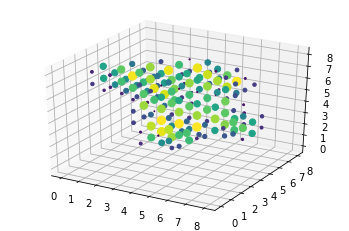

In [31]:
print(len(voxel_validation_generator))
v = voxel_validation_generator[11][0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_voxels(v, resolution=9, point_size=70)

In [32]:
#General callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)

a) Simple dense neural network

In [9]:
model_dense_voxel_mse = Sequential()
model_dense_voxel_mse.add(Flatten(input_shape=(9, 9, 9, 1))) 
model_dense_voxel_mse.add(Dense(1024,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel_mse.add(Dense(256,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel_mse.add(Dense(32,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel_mse.add(Dense(6, activation="tanh"))

W1221 18:58:02.496637 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1221 18:58:02.499027 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1221 18:58:02.508272 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [10]:
model_dense_voxel_mse.compile(optimizer = 'adam', 
                          loss = 'mse',
                          metrics = ['mse', 'mae', 'mape', 'cosine'])
model_dense_voxel_mse.summary()

W1221 18:58:02.564494 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 729)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              747520    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 1,018,342
Trainable params: 1,018,342
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Callbacks for dense
checkpoint_dense_voxel = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_dense_voxel_mse.hdf5', verbose=0,save_best_only=True)
store_result_dense_voxel = keras.callbacks.CSVLogger("results_dense_voxel_mse.csv", separator=',', append=False)

In [12]:
# Using workers=2, use_multiprocessing=True sometimes resulted in freeze
result_dense_voxel = model_dense_voxel_mse.fit_generator(voxel_training_generator, verbose=0, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                                     callbacks=[early_stopping, checkpoint_dense_voxel, store_result_dense_voxel, reduce_lr])
model_dense_voxel_mse.save(os.path.join("models", 'dense_voxel_mse.model'))

W1221 18:58:02.694747 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1221 18:58:02.838562 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1221 18:58:02.900729 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1221 18:58:02.955416 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1221 18:58:02.957458 14022247485

rmse_360_2 loss

In [13]:
model_dense_voxel = Sequential()
model_dense_voxel.add(Flatten(input_shape=(9, 9, 9, 1))) 
model_dense_voxel.add(Dense(1024,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel.add(Dense(256,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel.add(Dense(32,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_voxel.add(Dense(6, activation="tanh"))

model_dense_voxel.compile(optimizer = 'adam', 
                          loss = rmse_360_2,
                          metrics = ['mse', 'mae', 'mape', 'cosine'])
model_dense_voxel.summary()

# Callbacks for dense
checkpoint_dense_voxel = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_dense_voxel.hdf5', verbose=0, save_best_only=True)
store_result_dense_voxel = keras.callbacks.CSVLogger("results_dense_voxel.csv", separator=',', append=False)

result_dense_voxel = model_dense_voxel.fit_generator(voxel_training_generator, verbose=0, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                                     callbacks=[early_stopping, checkpoint_dense_voxel, store_result_dense_voxel, reduce_lr])
model_dense_voxel.save('models/dense_voxel.model')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 729)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              747520    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 1,018,342
Trainable params: 1,018,342
Non-trainable params: 0
_________________________________________________________________


b) Convolutional neural network

In [14]:
# Build convolutional neural net

model_cnn_voxels = Sequential()

model_cnn_voxels.add(Conv3D(16,(5,5,5), padding = 'same', activation = 'relu', input_shape = (9,9,9,1)))
model_cnn_voxels.add(BatchNormalization())
model_cnn_voxels.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels.add(Dropout(0.1))

model_cnn_voxels.add(Conv3D(32, (5,5,5), padding = 'same', activation = 'relu'))
model_cnn_voxels.add(BatchNormalization())
model_cnn_voxels.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels.add(Dropout(0.1))

model_cnn_voxels.add(Flatten())
model_cnn_voxels.add(Dense(128, activation = 'relu'))
model_cnn_voxels.add(Dense(6, activation="tanh"))

W1221 19:30:07.318838 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1221 19:30:07.333487 140222474856256 deprecation.py:506] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


rmse_360_2 loss:

In [15]:
model_cnn_voxels.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_cnn_voxels.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 9, 9, 9, 16)       2016      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 9, 16)       64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 4, 4, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 4, 16)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 4, 4, 32)       64032     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 4, 32)       128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 2, 2, 32)      

In [21]:
checkpoint_cnn_voxel = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cnn_voxel.hdf5', verbose=0, save_best_only=True)
store_result_cnn_voxel = keras.callbacks.CSVLogger("results_cnn_voxel.csv", separator=',', append=False)

In [33]:
result_cnn_voxels = model_cnn_voxels.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                                                   epochs=500, verbose=0,
                                                   callbacks=[early_stopping, checkpoint_cnn_voxel, store_result_cnn_voxel, reduce_lr, early_stopping])
model_cnn_voxels.save('models/cnn_voxel.model')

MSE loss:

In [34]:
model_cnn_voxels_mse = Sequential()

model_cnn_voxels_mse.add(Conv3D(16,(5,5,5), padding = 'same', activation = 'relu', input_shape = (9,9,9,1)))
model_cnn_voxels_mse.add(BatchNormalization())
model_cnn_voxels_mse.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels_mse.add(Dropout(0.1))

model_cnn_voxels_mse.add(Conv3D(32, (5,5,5), padding = 'same', activation = 'relu'))
model_cnn_voxels_mse.add(BatchNormalization())
model_cnn_voxels_mse.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels_mse.add(Dropout(0.1))

model_cnn_voxels_mse.add(Flatten())
model_cnn_voxels_mse.add(Dense(128, activation = 'relu'))
model_cnn_voxels_mse.add(Dense(6, activation="tanh"))

model_cnn_voxels_mse.compile(optimizer = 'adam',
              loss = 'mse',
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_cnn_voxels_mse.summary()
checkpoint_cnn_voxel_mse = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cnn_voxel_mse.hdf5', verbose=0, save_best_only=True)
store_result_cnn_voxel_mse = keras.callbacks.CSVLogger("results_cnn_voxel_mse.csv", separator=',', append=False)
result_cnn_voxels_mse = model_cnn_voxels_mse.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                                                       epochs=500, verbose=0, 
                                                       callbacks=[early_stopping, checkpoint_cnn_voxel_mse, store_result_cnn_voxel_mse, reduce_lr])
model_cnn_voxels_mse.save('models/cnn_voxel_mse.model')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 9, 9, 9, 16)       2016      
_________________________________________________________________
batch_normalization_3 (Batch (None, 9, 9, 9, 16)       64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 4, 4, 16)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 4, 16)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 4, 4, 32)       64032     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 4, 32)       128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 2, 2, 2, 32)      

2.) Principal component analysis

In [19]:
pca_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(3, 3, 1), batch_size=32, column="pca")
pca_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(3, 3, 1), batch_size=32, column="pca")

In [20]:
model_pca = Sequential()
model_pca.add(Flatten(input_shape=(3, 3, 1))) 
model_pca.add(Dense(512,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_pca.add(Dense(64,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_pca.add(Dense(6, activation="tanh"))

In [21]:
model_pca.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_pca.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               5120      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 390       
Total params: 38,342
Trainable params: 38,342
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint_pca = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_pca.hdf5', verbose=0, save_best_only=True)
store_result_pca = keras.callbacks.CSVLogger("results_pca.csv", separator=',', append=False)

In [23]:
result_pca = model_pca.fit_generator(pca_training_generator, verbose=0, validation_data=pca_validation_generator,
                                           epochs=500, 
                                           callbacks=[early_stopping, checkpoint_pca, store_result_pca, reduce_lr])
model_pca.save('models/pca.model')

3.) Projection on plane

In [24]:
plane_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(128, 128, 1), batch_size=32, column="plane")
plane_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=32, column="plane")

In [25]:
model_plane = Sequential()

model_plane.add(Conv2D(16,(5,5), padding = 'same', activation = 'relu', input_shape = (128,128,1)))
model_plane.add(BatchNormalization())
model_plane.add(MaxPooling2D(pool_size = (2,2)))
model_plane.add(Dropout(0.1))

model_plane.add(Conv2D(32, (5,5), padding = 'same', activation = 'relu'))
model_plane.add(BatchNormalization())
model_plane.add(MaxPooling2D(pool_size = (2,2)))
model_plane.add(Dropout(0.1))

model_plane.add(Flatten())
model_plane.add(Dense(128, activation = 'relu'))
model_plane.add(Dense(6, activation="tanh"))

W1221 20:34:42.552045 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W1221 20:34:42.594791 140222474856256 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [26]:
model_plane.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_plane.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      416       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)       

In [27]:
checkpoint_plane = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cnn_plane.hdf5', verbose=0, save_best_only=True)
store_result_plane = keras.callbacks.CSVLogger("results_cnn_plane.csv", separator=',', append=False)

In [28]:
result_plane = model_plane.fit_generator(plane_training_generator, verbose=0, validation_data=plane_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_plane, store_result_plane, reduce_lr])
model_plane.save('models/cnn_plane.model')

b) Dense network

In [29]:
checkpoint_dense_plane = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_dense_plane.hdf5', verbose=0, save_best_only=True)
store_result_dense_plane = keras.callbacks.CSVLogger("results_dense_plane.csv", separator=',', append=False)

model_dense_plane = Sequential()
model_dense_plane.add(Flatten(input_shape=(128, 128, 1))) 
model_dense_plane.add(Dense(2048,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_plane.add(Dense(512,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_plane.add(Dense(64,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
model_dense_plane.add(Dense(6, activation="tanh"))

model_dense_plane.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])

result_dense_plane = model_dense_plane.fit_generator(plane_training_generator, verbose=0, validation_data=plane_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_dense_plane, store_result_dense_plane, reduce_lr])
model_dense_plane.save('models/dense_plane.model')

4.) Projection on cylinder

In [30]:
cylinder_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(128, 128, 1), batch_size=32, column="cylinder")
cylinder_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=32, column="cylinder")

model_cylinder = Sequential()
model_cylinder.add(Conv2D(16,(5,5), padding = 'same', activation = 'relu', input_shape = (128,128,1)))
model_cylinder.add(BatchNormalization())
model_cylinder.add(MaxPooling2D(pool_size = (2,2)))
model_cylinder.add(Dropout(0.1))
model_cylinder.add(Conv2D(32, (5,5), padding = 'same', activation = 'relu'))
model_cylinder.add(BatchNormalization())
model_cylinder.add(MaxPooling2D(pool_size = (2,2)))
model_cylinder.add(Dropout(0.1))
model_cylinder.add(Flatten())
model_cylinder.add(Dense(128, activation = 'relu'))
model_cylinder.add(Dense(6, activation="tanh"))

model_cylinder.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_cylinder.summary()

checkpoint_cylinder = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_cylinder.hdf5', verbose=0, save_best_only=True)
store_result_cylinder = keras.callbacks.CSVLogger("results_cylinder.csv", separator=',', append=False)

result_cylinder = model_cylinder.fit_generator(cylinder_training_generator, verbose=0, validation_data=cylinder_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_cylinder, store_result_cylinder, reduce_lr])
model_cylinder.save('models/cylinder.model')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 16)      416       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)       

5.) Projection on sphere

In [9]:
sphere_training_generator = DataGenerator(data_path, num_features=30*30*15, dim=(128, 128, 1), batch_size=32, column="sphere")
sphere_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=32, column="sphere")

model_sphere = Sequential()
model_sphere.add(Conv2D(16,(5,5), padding = 'same', activation = 'relu', input_shape = (128,128,1)))
model_sphere.add(BatchNormalization())
model_sphere.add(MaxPooling2D(pool_size = (2,2)))
model_sphere.add(Dropout(0.1))
model_sphere.add(Conv2D(32, (5,5), padding = 'same', activation = 'relu'))
model_sphere.add(BatchNormalization())
model_sphere.add(MaxPooling2D(pool_size = (2,2)))
model_sphere.add(Dropout(0.1))
model_sphere.add(Flatten())
model_sphere.add(Dense(128, activation = 'relu'))
model_sphere.add(Dense(6, activation="tanh"))

model_sphere.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])
model_sphere.summary()

checkpoint_sphere = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_sphere.hdf5', verbose=0, save_best_only=True)
store_result_sphere = keras.callbacks.CSVLogger("results_sphere.csv", separator=',', append=False)

result_sphere = model_sphere.fit_generator(sphere_training_generator, verbose=0, validation_data=sphere_validation_generator,
                                                 epochs=500, 
                                                 callbacks=[early_stopping, checkpoint_sphere, store_result_sphere, reduce_lr])
model_sphere.save('models/sphere.model')

W1222 00:23:09.225763 140358792763200 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1222 00:23:09.232774 140358792763200 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1222 00:23:09.237117 140358792763200 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1222 00:23:09.262889 140358792763200 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1222 00

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)       

W1222 00:23:11.423224 140358792763200 module_wrapper.py:139] From /home/pawel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Example of prediction:

In [10]:
import keras
voxel_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(9, 9, 9, 1), batch_size=1, column="voxels", shuffle=False)
loaded_model = keras.models.load_model('models/cnn_voxel.model', custom_objects={'rmse_360_2': rmse_360_2})  
layer_outputs = [layer.output for layer in loaded_model.layers[:]]
multioutput_model = keras.Model(inputs=loaded_model.input, outputs=layer_outputs)
activations = multioutput_model.predict(voxel_validation_generator[5][0])

ModelVoxNet implementation, based on https://github.com/SnowMasaya/Generative-and-Discriminative-Voxel-Modeling-Keras/ made by SnowMasaya

In [11]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
# Source: https://github.com/SnowMasaya/Generative-and-Discriminative-Voxel-Modeling-Keras/blob/master/src/models/vox_net.py
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv3D, MaxPooling3D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from types import MappingProxyType


class ModelVoxNet(object):

    def __init__(self, number_class,
                 parameter_dict={
                     'input_shape': (9, 9, 9, 1),
                     'filter_size': 32,
                     'conv_kernel_size_1': 3,
                     'conv_kernel_size_2': 2,
                     'strides_1': (2, 2, 2),
                     'strides_2': (1, 1, 1),
                     'drop_out_rate_list': [0.3, 0.4, 0.5],
                     'pool_size': (2, 2, 2),
                     'units': 128
                 }
                 ):
        # init model

        default_parameter_dict = parameter_dict
        default_parameter_dict = MappingProxyType(default_parameter_dict)
        self.default_parameter_dict = default_parameter_dict

        count_dict = {}

        with tf.name_scope('Model'):
            with tf.name_scope('Inputs'):
                inputs = Input(default_parameter_dict['input_shape'])

            # convolution 1

            count_dict['Conv3D'] = 1

            with tf.name_scope('Conv3D_' + str(count_dict['Conv3D'])):
                x = Conv3D(filters=default_parameter_dict['filter_size'],
                           kernel_size=default_parameter_dict[
                               'conv_kernel_size_1'],
                           padding='valid',
                           strides=default_parameter_dict['strides_1'],
                           data_format='channels_last',
                           )(inputs)

            # Activation Leaky ReLu

            count_dict['Activation_relu'] = 1

            with tf.name_scope(
                    'Activation_relu_' + str(count_dict['Activation_relu'])):
                x = Activation('relu')(x)

            # dropout 1

            count_dict['Dropout'] = 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][0])(x)

            # convolution 2

            count_dict['Conv3D'] += 1

            with tf.name_scope('Conv3D_' + str(count_dict['Conv3D'])):
                x = Conv3D(filters=default_parameter_dict['filter_size'],
                           kernel_size=default_parameter_dict[
                               'conv_kernel_size_2'],
                           padding='valid',
                           strides=default_parameter_dict['strides_2'],
                           data_format='channels_last',
                           )(x)

            # Activation Leaky ReLu
            count_dict['Activation_relu'] += 1

            with tf.name_scope(
                    'Activation_relu_' + str(count_dict['Activation_relu'])):
                x = Activation('relu')(x)

            # max pool 1
            with tf.name_scope('MaxPooling3D'):
                x = MaxPooling3D(pool_size=default_parameter_dict['pool_size'],
                                 strides=None,
                                 padding='valid',
                                 data_format='channels_last',
                                 )(x)

            # dropout 2
            count_dict['Dropout'] += 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][2])(x)

            # dense 1 (fully connected layer)

            with tf.name_scope('Flatten'):
                x = Flatten()(x)

            count_dict['Dense'] = 1

            with tf.name_scope('Dense'):
                x = Dense(units=default_parameter_dict['units'],
                          activation='linear', )(x)

            # dropout 3
            count_dict['Dropout'] += 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][2])(x)

            # dense 2 (fully connected layer)

            count_dict['Dense'] += 1

            with tf.name_scope('Dense'):
                x = Dense(units=number_class,
                          activation='linear',
                          )(x)

            # Activation Softmax
            with tf.name_scope('Activation_softmax'):
                outputs = Activation("tanh")(x)

            self.model = Model(inputs=[inputs], outputs=[outputs])
            self.model.summary()
model_vox_net = ModelVoxNet(6).model

model_vox_net.compile(optimizer = 'adam',
              loss = rmse_360_2,
              metrics = ['mse', 'mae', 'mape', 'cosine'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9, 9, 9, 1)        0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 4, 4, 4, 32)       896       
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 4, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 4, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 3, 3, 32)       8224      
_________________________________________________________________
activation_2 (Activation)    (None, 3, 3, 3, 32)       0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 1, 1, 32)       0   

In [12]:
checkpoint_vox_net_voxel_net = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_vox_net_voxel.hdf5', verbose=0, save_best_only=True)
store_result_vox_net_voxel_net = keras.callbacks.CSVLogger("results_vox_net_voxel.csv", separator=',', append=False)
# Using workers=2, use_multiprocessing=True sometimes resulted in freeze
result_vox_net_voxel = model_vox_net.fit_generator(voxel_training_generator, verbose=0, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                                     callbacks=[early_stopping, checkpoint_vox_net_voxel_net, store_result_vox_net_voxel_net, reduce_lr])
model_vox_net.save('models/vox_net_voxel.model')

6.) Compare results

In [13]:
import sqlite3
import math
import time


voxel_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(9, 9, 9, 1), batch_size=1, column="voxels", shuffle=False)
pca_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(3, 3, 1), batch_size=1, column="pca", shuffle=False)
plane_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=1, column="plane", shuffle=False)
cylinder_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=1, column="cylinder", shuffle=False)
sphere_validation_generator = DataGenerator(data_test_path, num_features=13*13*6, dim=(128, 128, 1), batch_size=1, column="sphere", shuffle=False)


models = {   
    'dense_voxel_mse.model': voxel_validation_generator,
    'dense_voxel.model': voxel_validation_generator,
    'vox_net_voxel.model': voxel_validation_generator,
    'cnn_voxel.model': voxel_validation_generator,
    'cnn_voxel_mse.model': voxel_validation_generator,
    'pca.model': pca_validation_generator,
    'cnn_plane.model': plane_validation_generator,
    'dense_plane.model': plane_validation_generator,
    'cylinder.model': cylinder_validation_generator,
    'sphere.model': sphere_validation_generator
}


def to_angle(arr):
    return arr
    angles = math.atan2(arr[0], arr[1]), math.atan2(arr[2], arr[3]), math.atan2(arr[4], arr[5])
    return [math.degrees(x) for x in angles]

real_angles = pca_validation_generator[5][1][0]
print("Real value: ", to_angle(real_angles))

for saved_model, generator in models.items():
    model = keras.models.load_model(os.path.join("models", saved_model), custom_objects={'rmse_360_2': rmse_360_2})  
    pred = model.predict(generator[5][0])    
    print("{}:\nResult: {}\nMSE: {}\n\n".format(saved_model, to_angle(pred[0]), sum([(x - y)**2 for x, y in zip(to_angle(pred[0]), real_angles)])**0.5))

Real value:  [ 0.          1.          0.          1.          0.66312266 -0.74851075]
dense_voxel_mse.model:
Result: [0.07755815 0.09418971 0.08153607 0.0880119  0.03703671 0.11661583]
MSE: 1.6749046496664837


dense_voxel.model:
Result: [ 0.37412435  0.98741835 -0.34740022  0.9188149   0.59011436 -0.99241716]
MSE: 0.5763903249239825


vox_net_voxel.model:
Result: [ 0.02217422  0.13018447 -0.18923718  0.16984844 -0.00587346  0.06353476]
MSE: 1.6090390840062745


cnn_voxel.model:
Result: [ 0.17663889  0.9647745   0.3315162   0.9999777   0.8142972  -0.85835266]
MSE: 0.4210274527471803


cnn_voxel_mse.model:
Result: [ 0.12286221  0.9968798   0.01918642  0.99977314  0.6963048  -0.8421781 ]
MSE: 0.15920947609940703


pca.model:
Result: [ 0.03832373  0.931048   -0.03210604  0.9383117   0.5575298  -0.1552798 ]
MSE: 0.6116634225277489


cnn_plane.model:
Result: [ 1. -1.  1. -1. -1.  1.]
MSE: 3.9778470072168175


dense_plane.model:
Result: [7.40240142e-02 1.21158428e-01 6.76887855e-02 1.203226

Plot results of fitting:

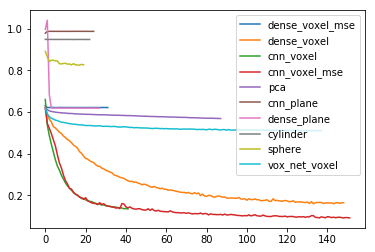

In [14]:
import csv
import pandas as pd

results = [
    "results_dense_voxel_mse.csv",
    "results_dense_voxel.csv",
    "results_cnn_voxel.csv",
    "results_cnn_voxel_mse.csv",
    "results_pca.csv",
    "results_cnn_plane.csv",
    "results_dense_plane.csv",
    "results_cylinder.csv",
    "results_sphere.csv",
    "results_vox_net_voxel.csv"
    ]

all_results_list = dict()
handles = list()
for result in  results:
    name = result.replace("results_", "").split(".")[0]
    results_dict = {
        "loss": list(), 
        "val_loss": list()
    }
    with open(result, newline='') as csvfile:
        for num, row in enumerate(csv.reader(csvfile, delimiter=',', quotechar='|')):
            if num == 0:
                continue
            results_dict["loss"].append(float(row[1]))
            results_dict["val_loss"].append(float(row[3]))
    all_results_list[name] = pd.DataFrame.from_dict(results_dict)
    p = plt.plot(all_results_list[name]["val_loss"], label=name)
    plt.legend()

7) CNN exploration: Examples of filters generated by networks:

<Figure size 8000x800 with 0 Axes>

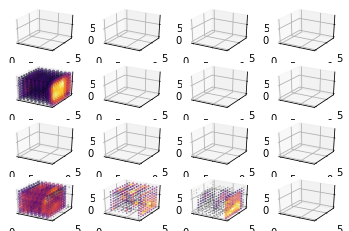

In [15]:
def plot_voxels_2(nvoxels, ax, resolution=9, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels[x, z, y, 0] )**2)
    ax.scatter(xs, ys, zs, s=sizes, c=sizes, alpha=alpha, cmap='inferno', marker="o")

fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))

axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[0][0][:, :, :, i].reshape((9, 9, 9, 1)), axs[i], resolution=9, point_size=1, alpha=.5)

<Figure size 8000x800 with 0 Axes>

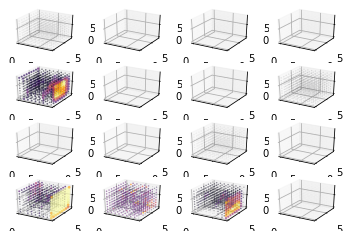

In [16]:
fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))

axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[1][0][:, :, :, i].reshape((9, 9, 9, 1)), axs[i], resolution=9, point_size=1, alpha=.5)

<Figure size 8000x800 with 0 Axes>

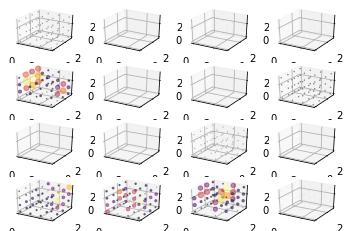

In [17]:
fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))
axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[2][0][:, :, :, i].reshape((4, 4, 4, 1)), axs[i], resolution=4, point_size=30, alpha=.5)

<Figure size 8000x800 with 0 Axes>

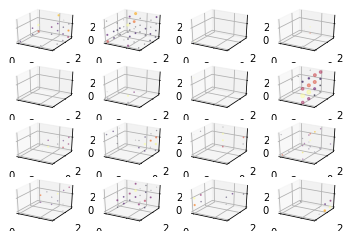

In [18]:
fig = plt.figure(figsize=(100, 10), dpi= 80)
#ax = fig.add_subplot(111, projection='3d')
fig, ((ax1, ax2, ax3,  ax4), 
      (ax5, ax6, ax7, ax8),
     (ax9, ax10, ax11, ax12),
     (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4, subplot_kw=dict(projection='3d'))
def plot_voxels_2(nvoxels, ax, resolution=9, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels[x, z, y, 0] )**2)
    ax.scatter(xs, ys, zs, s=sizes, c=sizes, alpha=alpha, cmap='inferno', marker="o")
axs = (ax1, ax2, ax3,  ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16)
for i in range(16):
    #plt.matshow(activations[0][0, :, :, i], cmap='viridis')
    plot_voxels_2(activations[4][0][:, :, :, i].reshape((4, 4, 4, 1)), axs[i], resolution=4, point_size=1, alpha=.5)

cnn_voxel and cnn_voxel_mse are by far the best performing networks, so they will be trained more and usedlater.

In [24]:
model_cnn_voxels = keras.models.load_model(os.path.join("models", 'cnn_voxel.model'), custom_objects={'rmse_360_2': rmse_360_2})  
model_cnn_voxels.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                               epochs=500, callbacks=[checkpoint_cnn_voxel, store_result_cnn_voxel, reduce_lr], verbose=0)
model_cnn_voxels.save(os.path.join("models", 'cnn_voxel.model'))

model_cnn_voxels_mse = keras.models.load_model(os.path.join("models", 'cnn_voxel_mse.model'), custom_objects={'rmse_360_2': rmse_360_2})  
model_cnn_voxels_mse.fit_generator(generator=voxel_training_generator, validation_data=voxel_validation_generator,
                               epochs=500, callbacks=[checkpoint_cnn_voxel, store_result_cnn_voxel, reduce_lr], verbose=0)
model_cnn_voxels_mse.save(os.path.join("models", 'cnn_voxel_mse.model'))